## Transfer Learing
- Dataset: clean-messy room Classification Dataset
- Reference: pytorch Transfer Learning Tutorial by `Sasank Chilamkurthy <https://chsasank.github.io>`

## Fine Tuning vs Feature extraction
&nbsp; Fine Tuning(미세조정)과 Feature Extraction(특징 추출)은 기존에 이미 학습된 모형이 있을 때, 새로운 데이터로 추가적인 학습을 원할때 하는 방법을 말한다.

### 1. Feature Extraction 

&nbsp;기존 가중치는 그대로 놔둔뒤, 새로운 레이어를 추가해서 이를 학습하고 최종 결과를 내게끔 학습하는 방법이다. 기존 모형이 좋은 모형이라면 새로운 층의 가중치만 업데이트하여도 좋은 성능을 얻을 수 있을 것이다.

### 2. Fine Tuning 

&nbsp;새로운 데이터로 다시한번 가중치를 세밀하게 조정하도록 학습하는 방법이다(기존 데이터는 기존대로 분류된다). Feature Extraction은 기존 모형과 새로운 데이터셋의 특징이 잘 맞다는 전제 하에서만 좋은 성능을 낼 수 있는 반면, Fine Tuning은 새로운 데이터로 가중치를 업데이트해주므로 Feature Extraction의 한계를 극복해낼 수 있다. 

In [0]:
%matplotlib inline

In [12]:
!git clone https://github.com/greenteaAde/DL_basic.git

Cloning into 'DL_basic'...
remote: Enumerating objects: 3540, done.
remote: Counting objects: 100% (3540/3540), done.
remote: Compressing objects: 100% (3536/3536), done.
remote: Total 3540 (delta 2), reused 3540 (delta 2), pack-reused 0
Receiving objects: 100% (3540/3540), 628.80 MiB | 46.72 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [13]:
ls

DL_basic/  sample_data/


In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'DL_basic'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

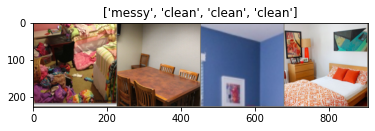

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the Model
------------------

define function for training model



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Fine-tuning (ResNET18)
----------------------

Load a pretrained model and reset final fully connected layer.




In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6188 Acc: 0.6927
val Loss: 0.2975 Acc: 0.8500

Epoch 1/24
----------
train Loss: 0.4155 Acc: 0.8438
val Loss: 0.0955 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.6027 Acc: 0.7760
val Loss: 0.1673 Acc: 0.9500

Epoch 3/24
----------
train Loss: 0.4465 Acc: 0.8490
val Loss: 0.2321 Acc: 0.8500

Epoch 4/24
----------
train Loss: 0.3372 Acc: 0.8385
val Loss: 0.2410 Acc: 0.9500

Epoch 5/24
----------
train Loss: 0.4497 Acc: 0.8490
val Loss: 0.2695 Acc: 0.9000

Epoch 6/24
----------
train Loss: 0.6731 Acc: 0.7760
val Loss: 0.0348 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.3733 Acc: 0.8229
val Loss: 0.0896 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.4122 Acc: 0.8385
val Loss: 0.0502 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.3286 Acc: 0.8646
val Loss: 0.0447 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.3002 Acc: 0.9115
val Loss: 0.0440 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1830 Acc: 0.9323
val Loss: 0.0516 Acc: 1.0000

Epoch 12/24
----------
t

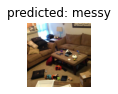

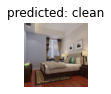

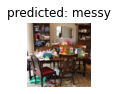

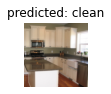

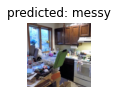

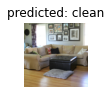

In [23]:
visualize_model(model_ft)

Feature Extraction (ResNET18)
----------------------------------

Freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [26]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6253 Acc: 0.7500
val Loss: 0.4168 Acc: 0.9000

Epoch 1/24
----------
train Loss: 0.3824 Acc: 0.8385
val Loss: 0.2038 Acc: 0.8500

Epoch 2/24
----------
train Loss: 0.3870 Acc: 0.8177
val Loss: 0.1969 Acc: 0.8500

Epoch 3/24
----------
train Loss: 0.3426 Acc: 0.8750
val Loss: 0.1943 Acc: 0.9000

Epoch 4/24
----------
train Loss: 0.4157 Acc: 0.8021
val Loss: 0.1930 Acc: 0.8500

Epoch 5/24
----------
train Loss: 0.3411 Acc: 0.8490
val Loss: 0.1856 Acc: 0.9500

Epoch 6/24
----------
train Loss: 0.2737 Acc: 0.8906
val Loss: 0.1699 Acc: 0.8500

Epoch 7/24
----------
train Loss: 0.3744 Acc: 0.8698
val Loss: 0.1775 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.3382 Acc: 0.8438
val Loss: 0.1864 Acc: 0.9500

Epoch 9/24
----------
train Loss: 0.2781 Acc: 0.9010
val Loss: 0.1807 Acc: 0.9500

Epoch 10/24
----------
train Loss: 0.2241 Acc: 0.9115
val Loss: 0.1590 Acc: 0.9500

Epoch 11/24
----------
train Loss: 0.3607 Acc: 0.8542
val Loss: 0.1712 Acc: 0.9500

Ep

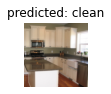

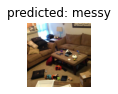

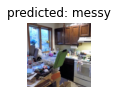

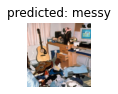

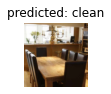

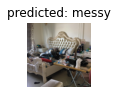

In [27]:
visualize_model(model_conv)

plt.ioff()
plt.show()

The Validation Accuray of Fine-tuning was higher than that of Feature Extraction.